In [78]:
from torch.utils.data import Dataset, DataLoader
import librosa
import matplotlib.pyplot as plt

In [1]:
from src.datasets import get_dataset
from src.visualization import play_audio, plot_specgram, plot_waveform, visualize_random_sample, calculate_statistics, plot_mfccs

## Problem Definition

## Dataset
LIBRISPEECH
LibriSpeech is a corpus of approximately 1000 hours of 16kHz read English speech, prepared by Vassil Panayotov with the assistance of Daniel Povey. The data is derived from read audiobooks from the LibriVox project, and has been carefully segmented and aligned.

Section contents:
- Visualize random sample
- Calculate dataset statistics

In [2]:
dataset_name = "librispeech"
dataset = get_dataset(dataset_name)

You're about to download librispeech with url dev-clean

 Done downloading


#### Visualizing data in random sample

waveform:  tensor([[-2.7466e-04, -2.4414e-04, -4.5776e-04,  ..., -6.1035e-05,
          6.1035e-05,  0.0000e+00]])
sample_rate:  16000
transcript:  STRUGGLE WARFARE WAS THE CONDITION OF PRIVATE OWNERSHIP IT WAS FATAL
speaker_id:  777


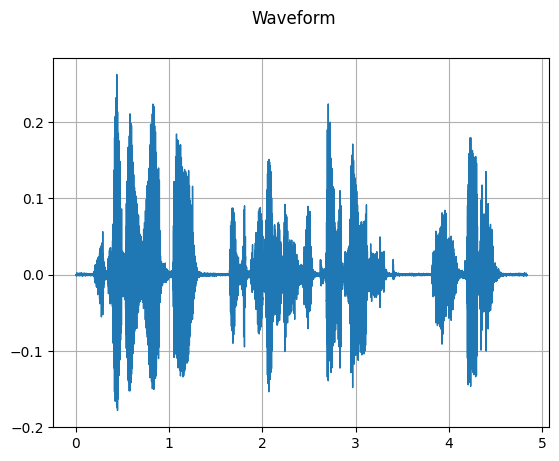

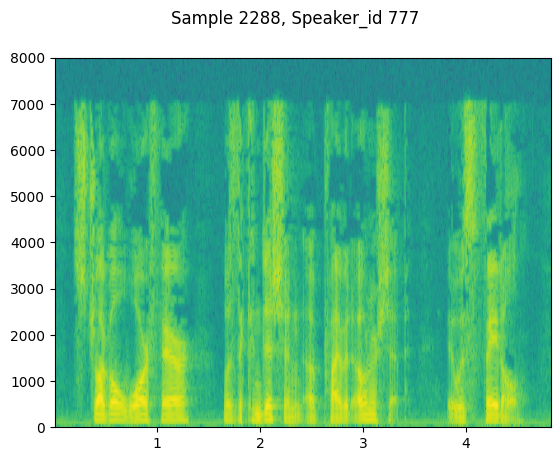

In [3]:
visualize_random_sample(dataset, plot_wave=True, plot_spectogram=True)

#### Calculate statistics in dataset

In [4]:
import pandas as pd
import numpy as np

In [5]:
waveform_lengths = []
sample_rates = []
transcript_lengths = []
speaker_ids = []
audio_durations = []    

for i in range(dataset.__len__()):
    (waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id) = dataset.__getitem__(i)
    waveform_lengths.append(waveform[0].shape[0])
    sample_rates.append(sample_rate)
    transcript_lengths.append(len(transcript))
    speaker_ids.append(speaker_id)

    num_channels, num_frames = waveform.shape
    duration = num_frames / sample_rate
    audio_durations.append(duration)

dataset_stats = pd.DataFrame.from_dict(
{
    "waveform_lengths" : waveform_lengths,
    "sample_rates" : sample_rates,
    "transcript_lengths" : transcript_lengths,
    "audio_durations" : audio_durations,
}
    )

In [6]:
df_spkr = pd.DataFrame(columns=['speaker_id', 'duration'])
df_spkr['speaker_id'] = speaker_ids
df_spkr['duration'] = audio_durations

Because on average the duration of each speaker is 4.8 or higher, we decided to use a window_size of 4 seconds. Samples shorter than 4 seconds will be removed from the dataset

In [30]:
df_spkr.groupby('speaker_id').mean().sort_values(by='duration', ascending=True)

,duration
speaker_id,
3752,4.788218
2277,5.057843
6313,5.105885
1462,5.129628
3081,5.335724
2428,5.528563
5694,5.790181
777,5.898658
5895,6.016188


Number of samples for each speaker

In [24]:
df_spkr.groupby('speaker_id').size().sort_values()

speaker_id
422      36
2902     38
3576     41
1673     42
3000     47
3170     49
2078     52
6319     55
2086     55
8842     55
2803     57
3853     57
1993     58
2412     58
174      59
5536     59
5338     59
1919     64
3536     64
84       65
652      71
7850     72
1272     73
6295     74
1988     75
8297     75
251      75
6345     77
2035     77
6241     78
7976     78
5895     80
777      82
5694     83
2428     87
3081     90
1462     94
2277     95
6313     96
3752    101
dtype: int64

Dataset has 2703 samples
Random samples has shape: torch.Size([1, 93680])
Unique speaker ids: 40


,waveform_lengths,sample_rates,transcript_lengths,audio_durations
min,23120.0,16000.0,3.0,1.0
std,75130.0,0.0,74.0,5.0
min,23120.0,16000.0,3.0,1.0
max,522320.0,16000.0,516.0,33.0


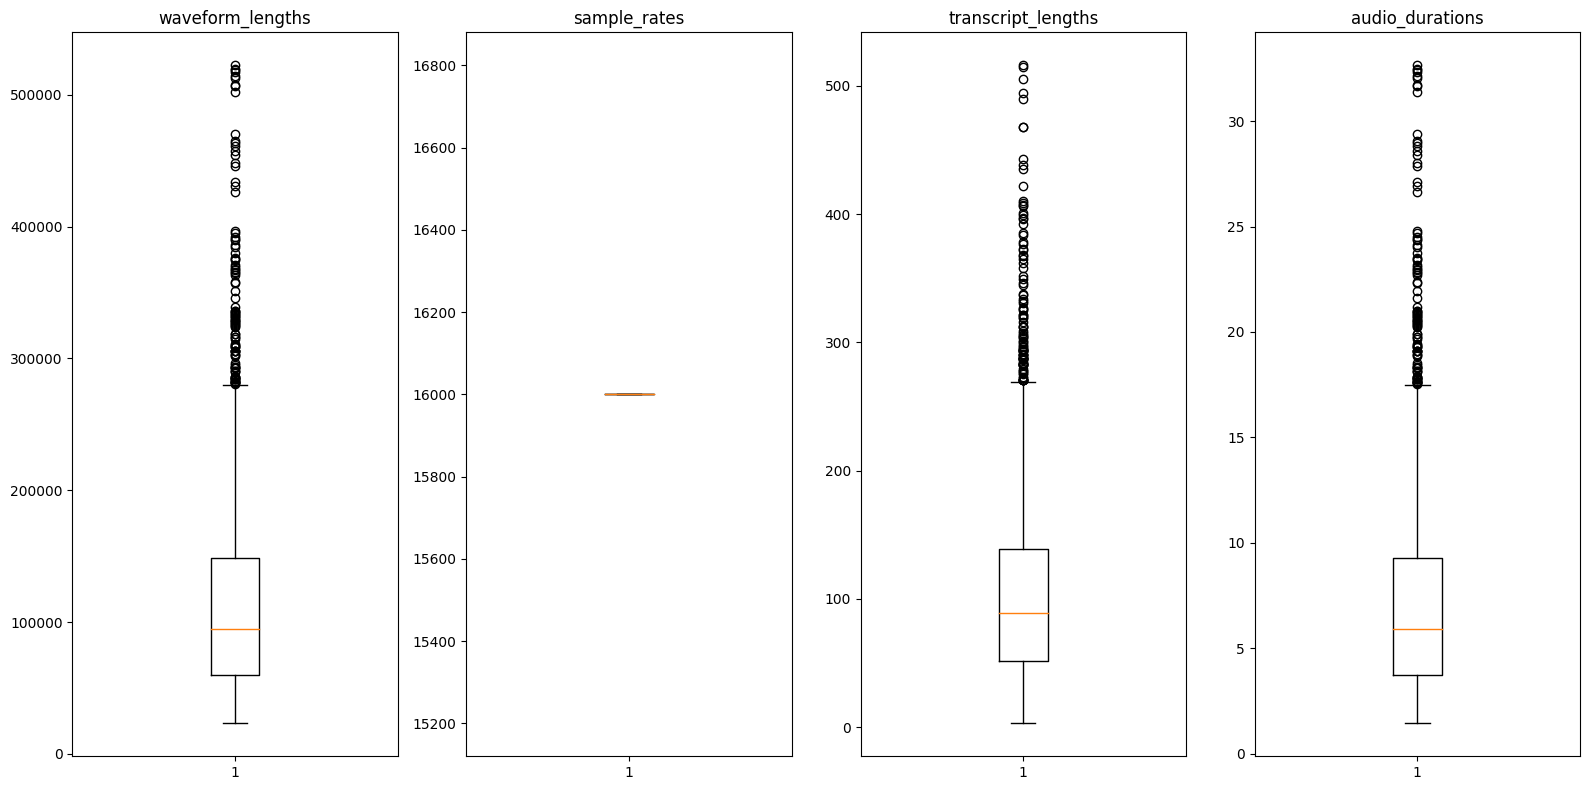

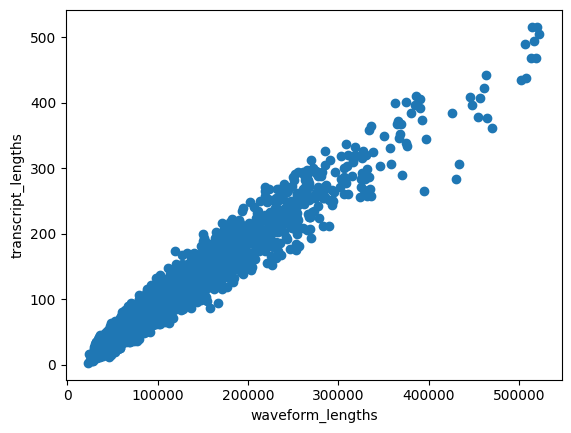

In [4]:
df = calculate_statistics(dataset)

## Preprocessing

In [7]:
def split_waveform(waveform : np.array, window_size : int) -> list[np.array]:
    """
    Takes an original waveform and reduce to chunks of smaller intervals using a sliding window
    
    waveform : nd.array
    
    window_size : int
        window size in seconds
    
    Returns
    -------
    splitted_waveform : list[nd.array]
        list of waverforms
    
    """
    splitted_waveform = []
    
    for i in range(0, len(waveform), window_size):
        split = waveform[i:i+window_size]
        if len(split) == window_size:
            splitted_waveform.append(split)

    return splitted_waveform

In [34]:
sample_rate = 16000 # 16kHz
window_size = 4 * sample_rate # 1 second has 16000 samples, window_size is 4 seconds

batch_size = 10

We decided to normalize our data by using the mean and variance of the amplitude. The normalizer is fitted on the whole training set, not for each speaker. The reasoning for this is that in our problem, we do not know ahead of time who the speaker is.

In [84]:
from sklearn.model_selection import train_test_split

In [87]:
TRAIN_PCT + VAL_PCT + TEST_PCT

0.9999999999999999

In [89]:
TRAIN_PCT = 0.70
VAL_PCT = 0.20
TEST_PCT = 0.10

In [155]:
class MFCCData(Dataset):
    def __init__(self, dataset, window_size : int, sample_rate : int, train_val_test : str):
        """
        Creates a dataset of spectrograms from a dataset of waveforms
        
        train_test_val : str
            one of 'train', 'validation', or 'test'
        """
        self.dataset = dataset
        self.window_size = window_size        
        self.sample_rate = sample_rate
        self.train_val_test = train_val_test
        
        self.transform_to_mfcc()
        self.split_train_test_val()

    def transform_to_mfcc(self):
        """
        Transforms waveforms into MFCC spectrograms
        """
        
        self.waveform_speaker_pairs = []
        
        for i in range(self.dataset.__len__()):
            (waveform, sample_rate, transcript, speaker_id, chapter_id, utterance_id) = dataset.__getitem__(i)
            waveform_arr = waveform.numpy().flatten()
            splitted_waveform = split_waveform(waveform_arr, self.window_size)
            
            for chunk in splitted_waveform:
                mfccs = librosa.feature.mfcc(y=chunk.flatten(), n_mfcc=13, sr=self.sample_rate)
                self.waveform_speaker_pairs.append([mfccs, speaker_id])
            
    def split_train_test_val(self):
        x = np.asarray(self.waveform_speaker_pairs)[:,0]
        y = np.asarray(self.waveform_speaker_pairs)[:,1]
        x_train, x_val_test, y_train, y_val_test = train_test_split(x, y, test_size=VAL_PCT+TEST_PCT, train_size=TRAIN_PCT, shuffle=True)
        x_val, x_test, y_val, y_test = train_test_split(x_val_test, y_val_test, test_size=TEST_PCT/(VAL_PCT+TEST_PCT), train_size=VAL_PCT/(VAL_PCT+TEST_PCT), shuffle=True)
        
        if self.train_val_test == 'train':
                self.waveform_speaker_pairs = [[x_train[i], y_train[i]] for i in range(len(x_train))]
        elif self.train_val_test == 'validation':
                self.waveform_speaker_pairs = [[x_val[i], y_val[i]] for i in range(len(x_val))]
        elif self.train_val_test == 'test':
                self.waveform_speaker_pairs = [[x_test[i], y_test[i]] for i in range(len(x_test))]
            
    def __len__(self):
        return len(self.waveform_speaker_pairs)

    def __getitem__(self, idx):
        waveform = self.waveform_speaker_pairs[idx][0]
        speaker_id = self.waveform_speaker_pairs[idx][1]
        return waveform, speaker_id

In [247]:
def normalize_data(mfcc_dataset_train):
    columns = [f"x_{i}" for i in range(number_spectral_coeffients)]
    df_coeffs = pd.DataFrame(columns=columns)

    mfcc_mean = []
    mfcc_std = []

    j = 0
    for mfcc, _ in mfcc_dataset_train:
        for i in range(number_spectral_coeffients):
            df_coeffs.loc[j, f"x_{i}"] = mfcc[i,:]
        j += 1

    for i in range(number_spectral_coeffients):
        mfcc_mean.append(np.mean(np.hstack(df_coeffs[f"x_{i}"])))
        mfcc_std.append(np.std(np.hstack(df_coeffs[f"x_{i}"])))
    
    return mfcc_mean, mfcc_std

In [165]:
mfcc_dataset_train = MFCCData(dataset, window_size=window_size, sample_rate=sample_rate, train_val_test='train')
mfcc_dataset_val = MFCCData(dataset, window_size=window_size, sample_rate=sample_rate, train_val_test='validation')
mfcc_dataset_test = MFCCData(dataset, window_size=window_size, sample_rate=sample_rate, train_val_test='test')

/tmp/ipykernel_226653/1881475806.py:34: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x = np.asarray(self.waveform_speaker_pairs)[:,0]
/tmp/ipykernel_226653/1881475806.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  y = np.asarray(self.waveform_speaker_pairs)[:,1]


In [166]:
mfcc_dataset_train.__len__(), mfcc_dataset_val.__len__(), mfcc_dataset_test.__len__(),

(2399, 686, 343)

Normalize the data

In [267]:
mfcc_mean, mfcc_std = normalize_data(mfcc_dataset_train)
mfcc_dataset_train.waveform_speaker_pairs = np.array(mfcc_dataset_train.waveform_speaker_pairs)
for sample in mfcc_dataset_train.waveform_speaker_pairs:
    for i in range(13):
        sample[0][i,:] = (sample[0][i,:] - mfcc_mean[i]) / mfcc_std[i]

/tmp/ipykernel_226653/3123882664.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  mfcc_dataset_train.waveform_speaker_pairs = np.array(mfcc_dataset_train.waveform_speaker_pairs)


In [303]:
train_loader = DataLoader(mfcc_dataset_train, batch_size=batch_size, shuffle=True)

In [304]:
mfccs = []
i = 1
for mfcc, speaker_id in train_loader:
    mfccs.append(mfcc)
    i += 1
    if i == 4:
        break

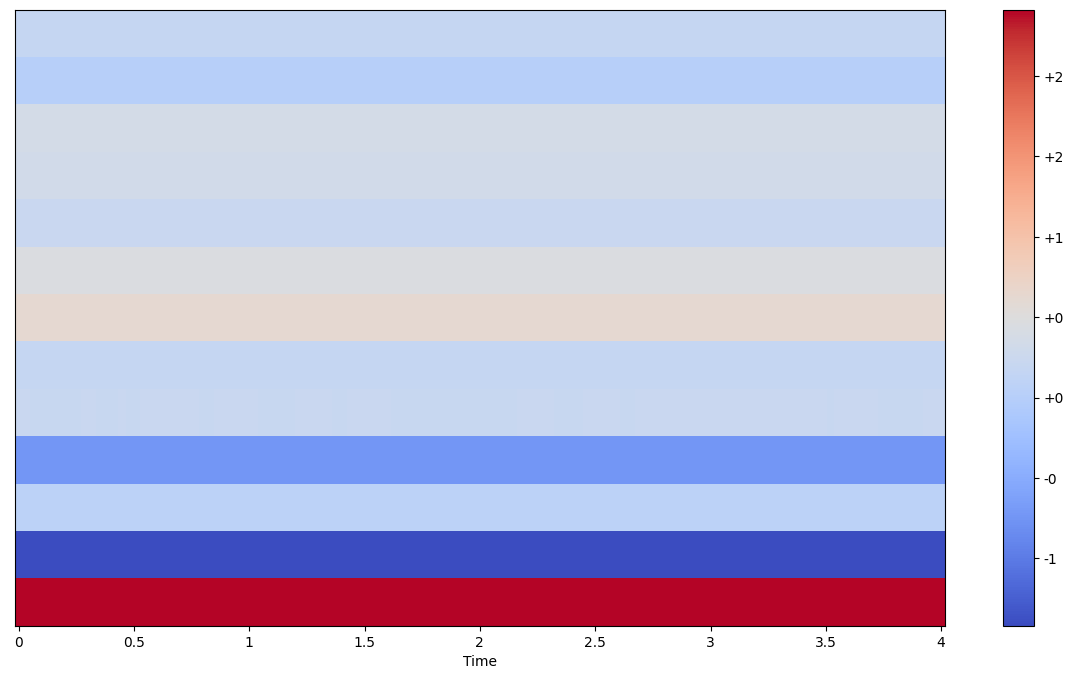

In [305]:
plt.figure(figsize=(15, 8))
librosa.display.specshow(mfcc[0].numpy(), x_axis="time", sr=sample_rate)
plt.colorbar(format="%+2.f")
plt.show()

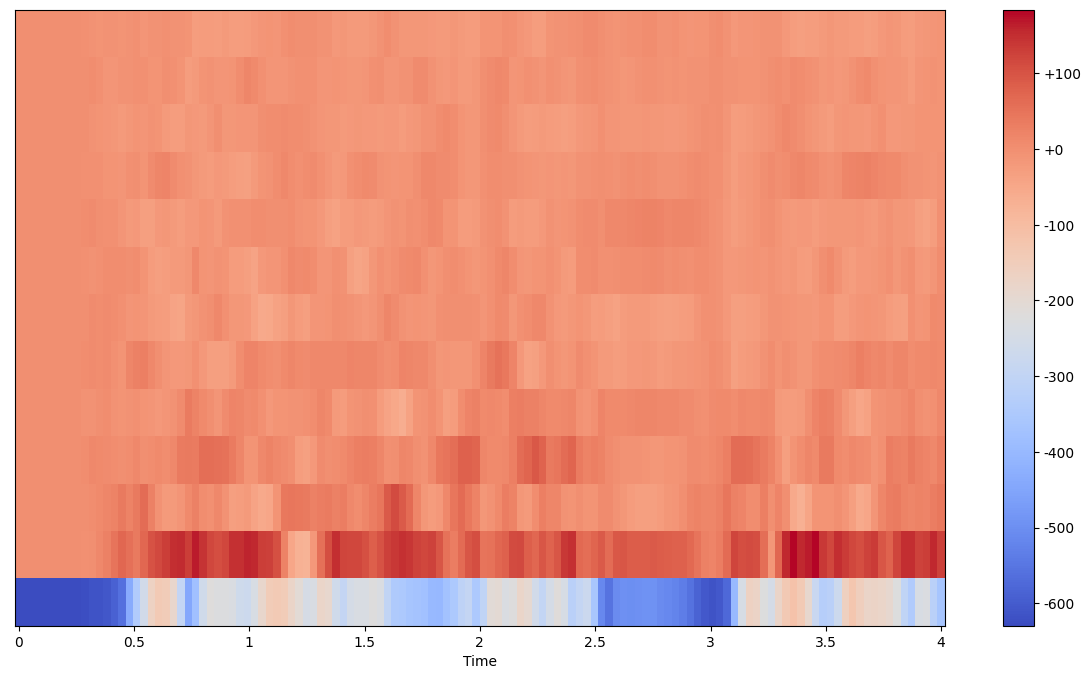

In [172]:
plt.figure(figsize=(15, 8))
librosa.display.specshow(mfcc[1].numpy(), x_axis="time", sr=sample_rate)
plt.colorbar(format="%+2.f")
plt.show()

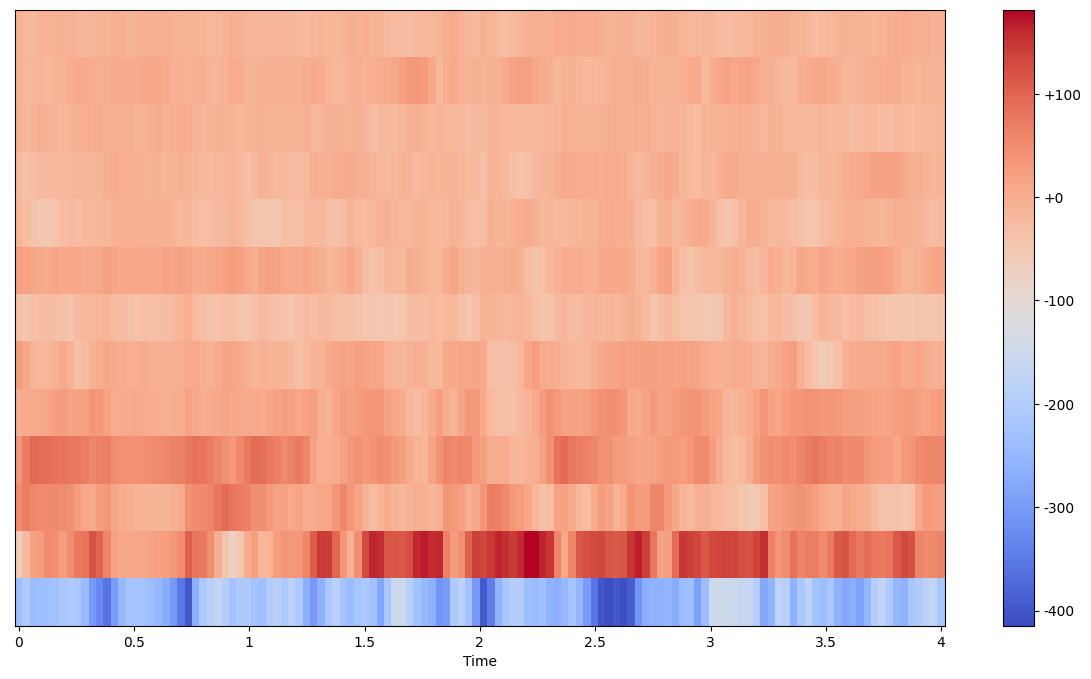

In [173]:
plt.figure(figsize=(15, 8))
librosa.display.specshow(mfcc[2].numpy(), x_axis="time", sr=sample_rate)
plt.colorbar(format="%+2.f")
plt.show()

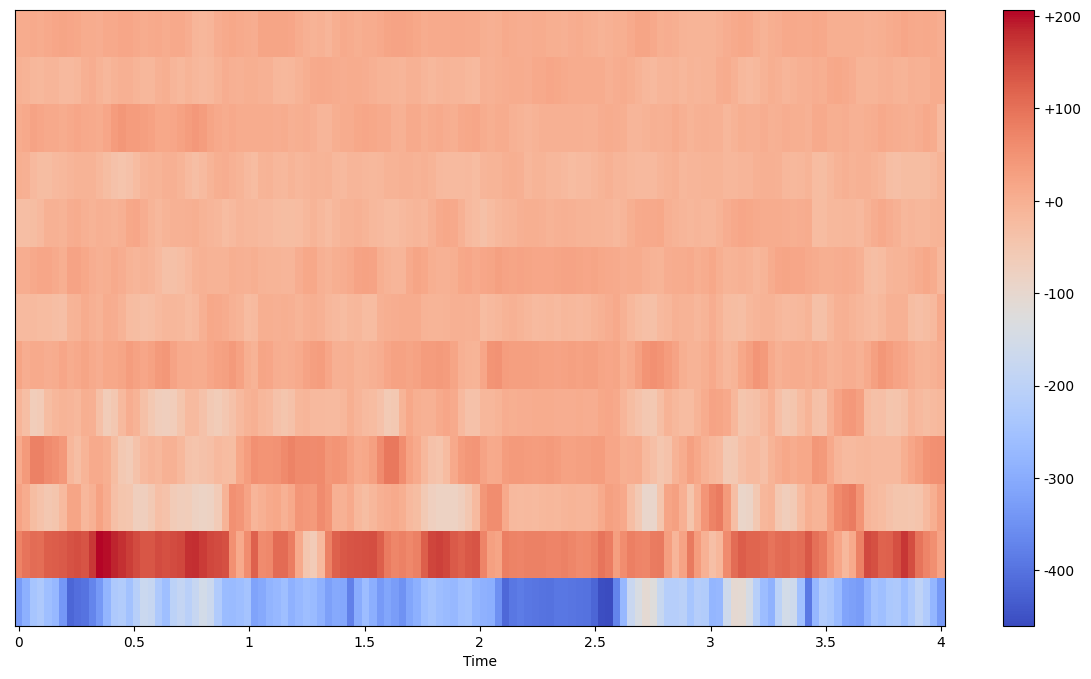

In [174]:
plt.figure(figsize=(15, 8))
librosa.display.specshow(mfcc[3].numpy(), x_axis="time", sr=sample_rate)
plt.colorbar(format="%+2.f")
plt.show()